In [1]:
import matplotlib as mpl
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA, KernelPCA, SparsePCA, FastICA, FactorAnalysis
import umap.umap_ as umap_
import hdbscan
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, SpectralEmbedding, MDS
import matplotlib.patches as mpatches
import re
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.random_projection import SparseRandomProjection
from unidecode import unidecode
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import nltk
import numpy as np
from matplotlib import pyplot as plt
import os
import shutil
from sklearn.metrics import silhouette_samples, silhouette_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

/home/rafael/.conda/envs/IA_TexT/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rafael/.conda/envs/IA_TexT/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rafael/.conda/envs/IA_TexT/lib/python3.8/site-packages/umap/distances.

In [2]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels_ = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels_)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                   .Doc
                   .count()
                   .reset_index()
                   .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                   .sort_values("Size", ascending=False))
    return topic_sizes


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def map_labels_to_colors(labels,cmap_):
    cmap = plt.get_cmap(cmap_)
    num_labels = np.max(labels) + 1
    colors = cmap(np.linspace(0, 1, num_labels))
    # print(colors)
    return colors[labels]


def gera_comparacao(list_preprossing_,cluster_):
    docs_df = pd.DataFrame(list_preprossing_,columns=["Doc"])
    docs_df['Topic'] = cluster_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic=docs_df.groupby(["Topic"],as_index=False).agg({"Doc":' '.join})
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(list_preprossing_))
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
    topic_sizes = extract_topic_sizes(docs_df)
    # print(top_n_words)
    legends=[top_n_words[i][0] for i in top_n_words]
    return  legends



In [3]:

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords_ = set(stopwords.words('portuguese'))


def preprocess_text(text):
    # Conversão para minúsculas
    text = text.lower()
    # Remoção de pontuações
    text = re.sub(r'[^\w\s]', '', text)
    # Remoção de caracteres especiais, preservando letras acentuadas
    text = re.sub(r'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôûÂÊÎÔÛàèìòùÀÈÌÒÙãõñÃÕÑçÇ\s]+', '', text)
    text = unidecode(text)
    return text

[nltk_data] Downloading package stopwords to /home/rafael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rafael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rafael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
name_types = {
                "ativo_indicacao_contra_indicacao_classes":[0,1,2,3]
}
lnp_models = [
                     'distiluse-base-multilingual-cased-v2',
]

df_train = pd.read_csv("./medicamentos_reduzidos")
# df_train = pd.read_excel("./medicamentos.xlsx")

df_train.head()
color_maps = 'tab20'
lemmatizer = WordNetLemmatizer()
figsize=(20,10)
list_preprossing=np.empty(0)

for row in df_train.itertuples():
    value=' '
    for data in row[1:]:
        value +=' '+str(data)
    # print(value)
    #     lemmas = nlp(preprocess_text(value.replace('nan','')))
    # for lemma in lemmas:
    #     print(lemma["lemma"])
    # print(preprocess_text(value.replace('nan','')))

    # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # filtered_text = ' '.join(filtered_tokens)
    # list_preprossing = np.append(list_preprossing,filtered_text)
    # break
    # tokens = tokenizer.tokenize(preprocess_text(value.replace('nan','')))
    # print(tokens)
    tokens = word_tokenize(preprocess_text(value.replace('nan','')))
    filtered_tokens = [token for token in tokens if token.lower() not in list(stopwords_)]
        # print(filtered_tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    filtered_text = ' '.join(lemmatized_tokens)
        # print(filtered_text)
    list_preprossing = np.append(list_preprossing,filtered_text)


print(list_preprossing)

['promestrieno promestrieno promestrieno indicado tratamento alteracoes troficas disturbios vulva vagina causadas reducao falta estrogenio organismo promestrieno tambem indicado acelerar cicatrizacao lesoes vagina colo utero periodo posparto normal poscirurgia apos terapias locais agentes fisicos voce nao deve utilizar promestrieno seguintes casos hipersensibilidade alergia conhecida promestrieno qualquer componentes formulacao amamentando utiliza produtos espermicidas historico suspeita cancer mama historico suspeita tumor maligno estrogeno dependente tal cancer endometrial sangramento vaginal causa desconhecida hiperplasia endometrial crescimento excessivamente anormal endometrio nao tratada antecedente quadro tromboembolismo venoso formacao coagulo dentro veia impedindo circulacao sangue tai trombose venosa profunda formacao coagulo sanguineo veia embolia pulmonar formacao coagulo pulmao disturbios trombofilicos diagnosticados tai deficiencia proteina c proteina s antitrombina vide 

In [5]:

corpus_embeddings = SentenceTransformer(lnp_models[0]).encode(list_preprossing,show_progress_bar=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
umap = umap_.UMAP(n_neighbors=2,n_components=2,metric='cosine')
reduce_embedding_umap=umap.fit_transform(corpus_embeddings)
kmeans = KMeans(n_clusters=7,n_init='auto').fit(reduce_embedding_umap)
result = pd.DataFrame(reduce_embedding_umap,columns=['x', 'y'])
reduce_embedding = reduce_embedding_umap
result['labels'] = kmeans.labels_
centroids = kmeans.cluster_centers_

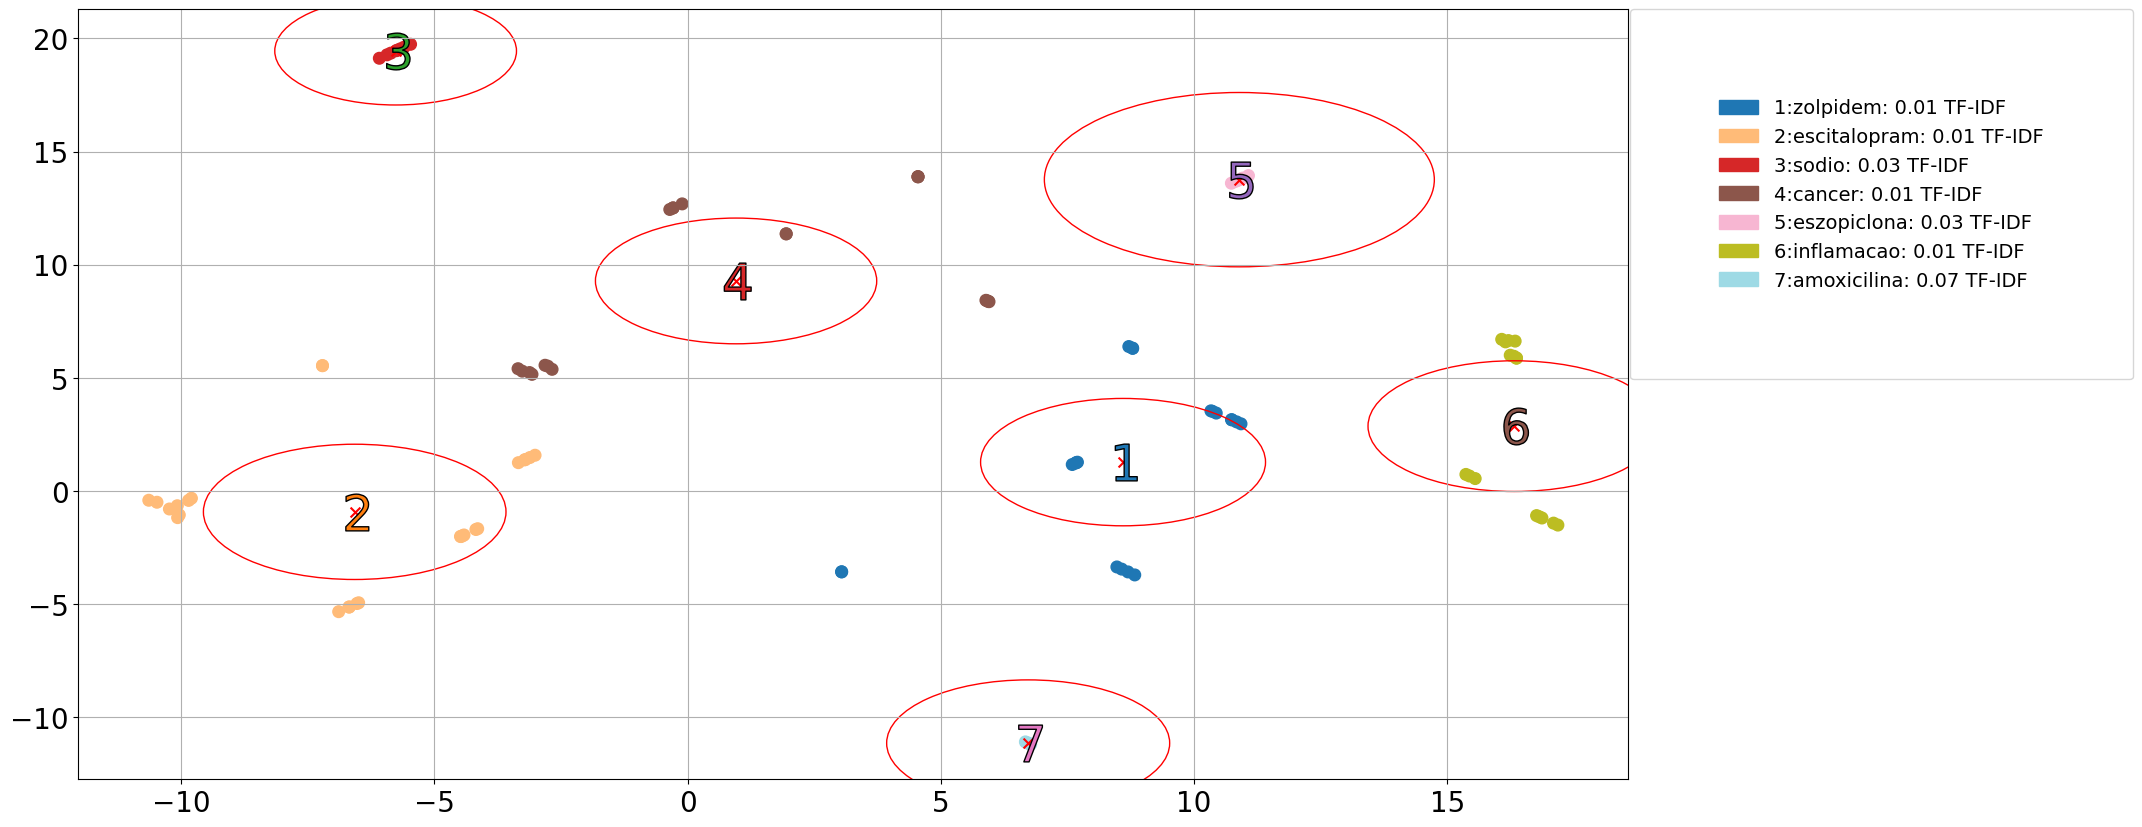

In [40]:
labels = gera_comparacao(list_preprossing, result['labels'].to_numpy())
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(result.x, result.y, c=result.labels, s=70,cmap=color_maps)
distances = pairwise_distances(result[['x', 'y']], centroids)
avg_distance = np.mean(distances, axis=1)
radius_factor = 0.2
adjusted_radius = avg_distance * radius_factor
for centroid, radius in zip(centroids, adjusted_radius):
    circle = plt.Circle((centroid[0], centroid[1]), radius=radius, color='red', fill=False)
    ax.add_artist(circle)
    plt.scatter(centroid[0], centroid[1], c='red', s=50, marker='x')

for i, c in enumerate(centroids):
    ax.scatter(c[0], c[1], marker='$%d$' % (i+1), alpha=1,
                s=700, edgecolor='k')

legend_labels = [f"{str(i+1)}:{label[0]}: {round(label[1], 2)} TF-IDF" for i, label in enumerate(labels)]
legend_colors = map_labels_to_colors(np.arange(len(legend_labels)), color_maps)
legend_elements = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Position the legend outside the plot on the right side
plt.legend(handles=legend_elements, bbox_to_anchor=(1.001,1), loc='upper left', borderaxespad=0.0, borderpad=4.6, fontsize=14)
plt.grid(True)
# plt.show()

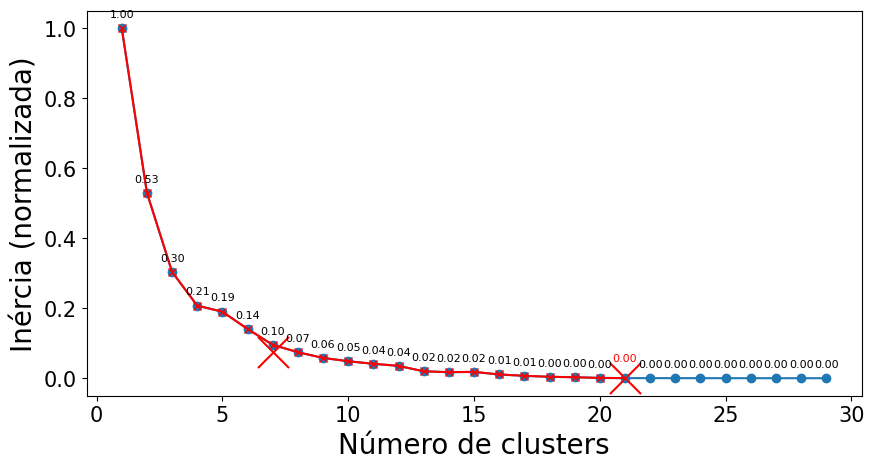

In [31]:
from sklearn.preprocessing import MinMaxScaler

variances = []
differences = []

x_clusters = 30
cluster_selecionado = 21


# Testar diferentes valores de k (número de clusters)
for k in range(1, x_clusters):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(reduce_embedding_umap)
    variances.append(kmeans.inertia_)  # Variância explicada

# Calcular as diferenças adjacentes
for i in range(1, len(variances) - 1):
    # diff = variances[i+1] - 2 * variances[i] + variances[i-1]
    diff = variances[i+1] -  variances[i]
    differences.append(diff)

# Normalizar os valores de variances e differences entre 0 e 1
scaler = MinMaxScaler()
variances_normalized = scaler.fit_transform(np.array(variances).reshape(-1, 1)).flatten()
differences_normalized = scaler.fit_transform(np.array(differences).reshape(-1, 1)).flatten()

# Encontrar o índice com a maior diferença na aceleração
max_diff_index = differences_normalized.argmax()

# Plotar a curva do método do cotovelo
fig, ax1= plt.subplots(1, figsize=(10,5))

ax1.plot(range(1, x_clusters), variances_normalized, marker='o')
ax1.plot(range(1, cluster_selecionado+1), [variances_normalized[i] for i in range(cluster_selecionado)], marker='x', c='r')
ax1.scatter(cluster_selecionado, variances_normalized[cluster_selecionado], marker='x',s=500, c='r')
ax1.scatter(7, variances_normalized[7], marker='x',s=500, c='r')
ax1.set_xlabel('Número de clusters',fontsize=20)
ax1.set_ylabel('Inércia (normalizada)',fontsize=20)
# ax1.set_title('Método de Elbow (Cotovelo)',fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i, var in enumerate(variances_normalized[:x_clusters]):
    if i == cluster_selecionado-1:
        ax1.annotate(f'{var:.2f}', (i+1, var), textcoords="offset points", xytext=(0,12), ha='center',font={'size':8},color='r')
    else:
        ax1.annotate(f'{var:.2f}', (i+1, var), textcoords="offset points", xytext=(0,8), ha='center',font={'size':8})

Text(0.5, 0.98, 'Análise Silhouette (silhueta) n_clusters = 7')

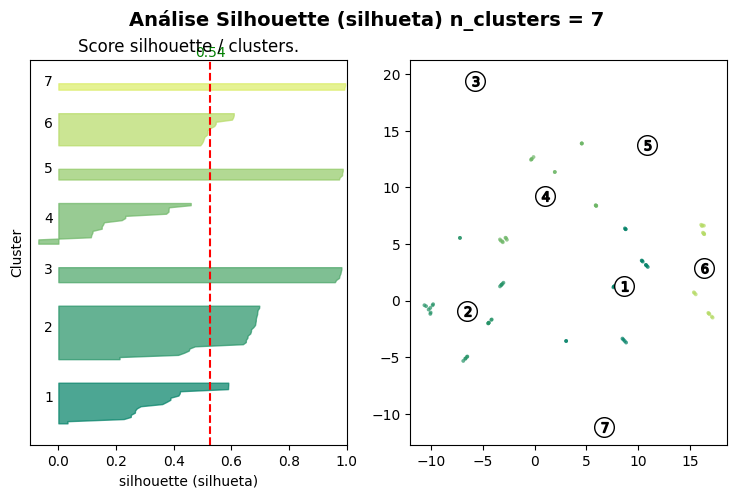

In [50]:
try:
    from matplotlib.cm import spectral as color_map
except ImportError:
    from matplotlib.cm import summer as color_map
silhouette_avg = silhouette_score(reduce_embedding, result["labels"].to_numpy())
sample_silhouette_values = silhouette_samples(reduce_embedding, result["labels"].to_numpy())

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,20))
fig.set_size_inches(9, 5)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(reduce_embedding) + (kmeans.n_clusters + 1) * 10])
centers = kmeans.cluster_centers_
n_clusters = centers.shape[0]
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = color_map(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
    y_lower = y_upper + 10

ax1.set_title("Score silhouette / clusters.")
ax1.set_xlabel("silhouette (silhueta)")
ax1.set_ylabel("Cluster")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.text(silhouette_avg, ax1.get_ylim()[1], f"{silhouette_avg+0.01:.2f}", va='bottom', ha='center', fontdict={'size':10},color='g')
ax1.set_yticks([])
ax1.set_xticks([ 0, 0.2, 0.4, 0.6, 0.8, 1])

colors = color_map(kmeans.labels_.astype(float) / n_clusters)
ax2.scatter(reduce_embedding[:, 0], reduce_embedding[:, 1], marker='.', s=30,
            lw=0, alpha=0.7, c=colors, edgecolor='k')
ax2.scatter(centers[:, 0],centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % (i+1), alpha=1,
                s=50, edgecolor='k')


plt.suptitle(("Análise Silhouette (silhueta)"
              " n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')